In [9]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, concatenate_datasets
from collections import Counter
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
    dataset = load_dataset('Lislaam/AggreFact', split=['validation[:]', 'test[:]'])
    dataset = concatenate_datasets([dataset[0], dataset[1]]) # Turn into one dataset to make new split

In [6]:
dataset

Dataset({
    features: ['dataset', 'origin', 'id', 'doc', 'summ', 'model_name', 'cut', 'error_type', 'annotated_span'],
    num_rows: 5485
})

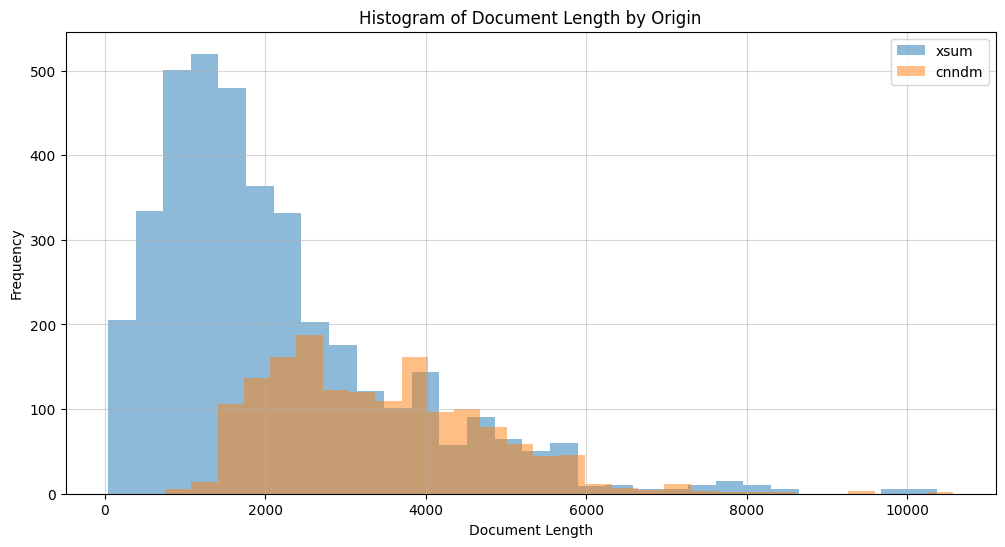

In [13]:
# Convert the dataset to a pandas DataFrame
df = dataset.to_pandas()

# Compute the length of each document
df['doc_length'] = df['doc'].apply(len)

# Define the two origins you want to compare
origin_1 = 'xsum'  # Replace with the actual value for the first origin
origin_2 = 'cnndm'  # Replace with the actual value for the second origin

# Filter the DataFrame for the two origins
df_origin_1 = df[df['origin'] == origin_1]
df_origin_2 = df[df['origin'] == origin_2]

# Plot histograms of document length for each origin
plt.figure(figsize=(12, 6))
plt.hist(df_origin_1['doc_length'], bins=30, alpha=0.5, label=origin_1)
plt.hist(df_origin_2['doc_length'], bins=30, alpha=0.5, label=origin_2)

# Add labels and title
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.title('Histogram of Document Length by Origin')
plt.legend(loc='upper right')
plt.grid(alpha=0.5)

# Show the plot
plt.show()

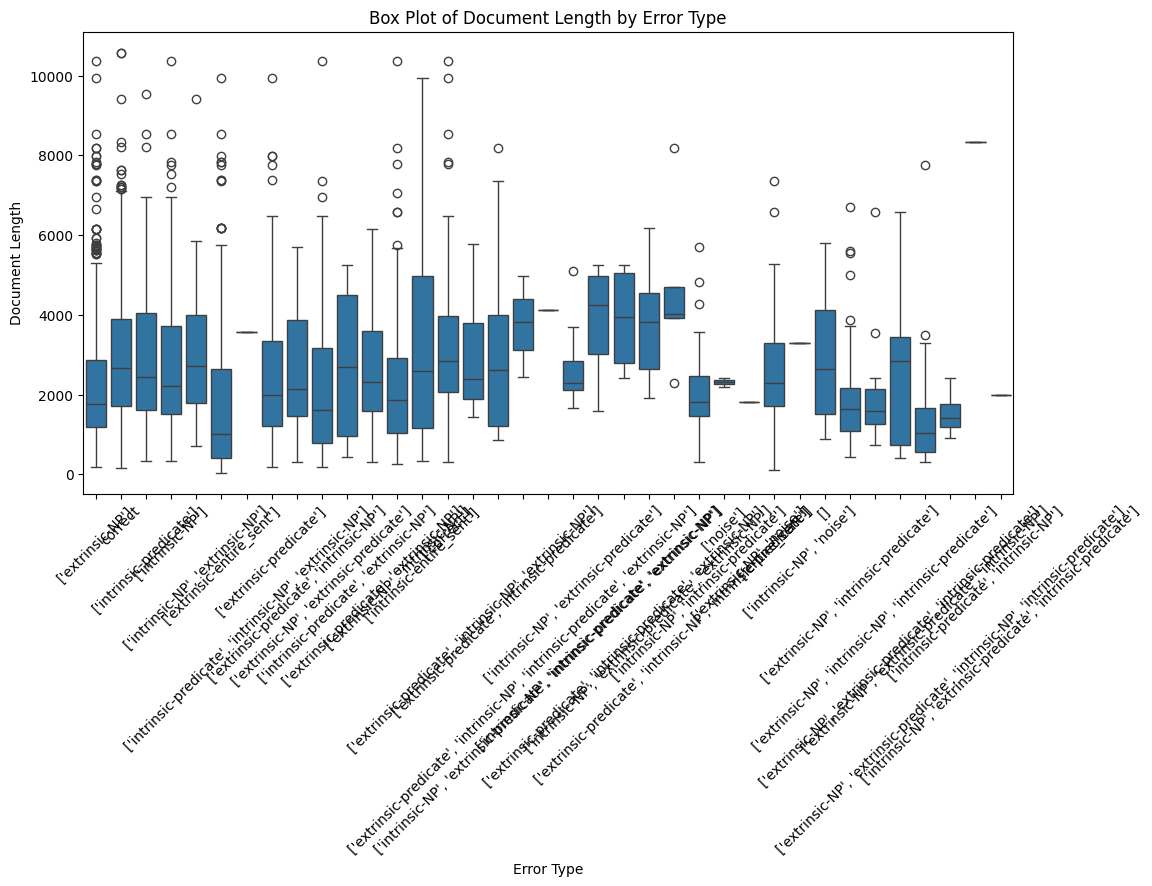

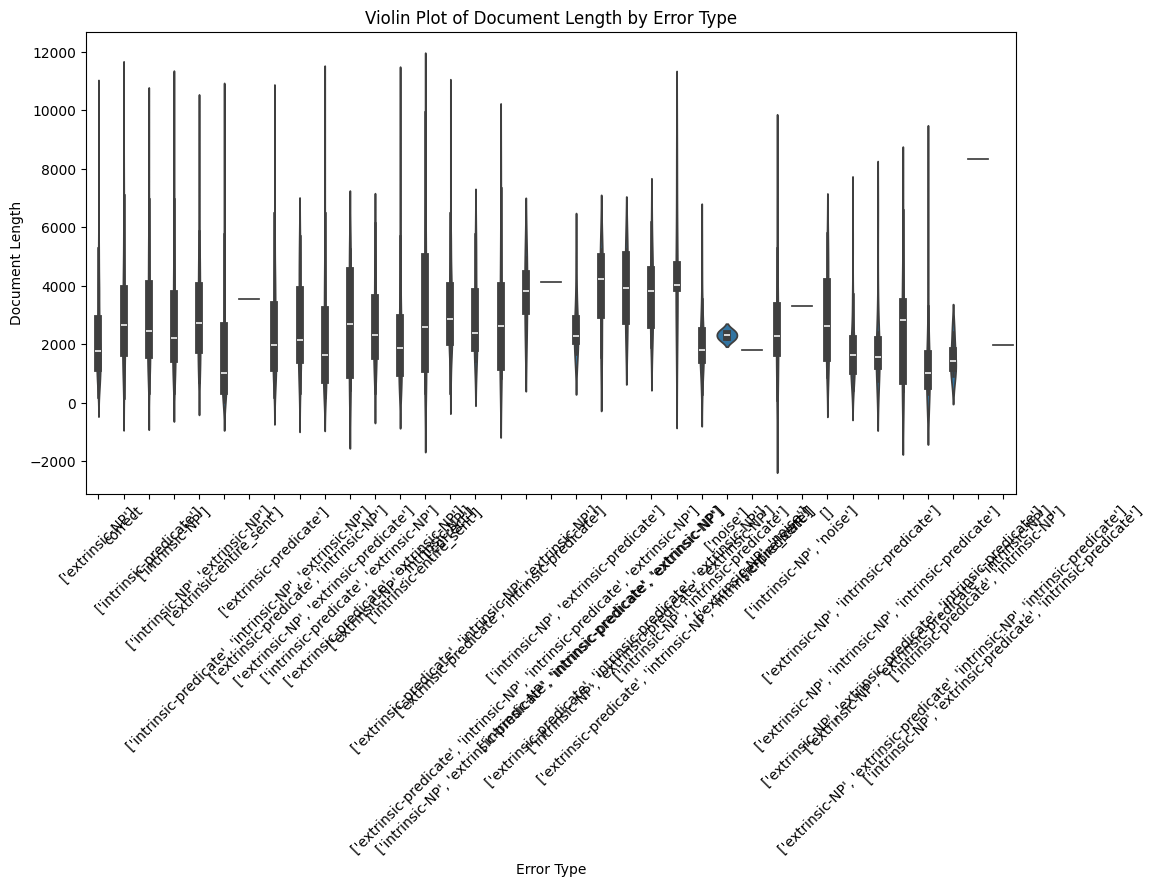

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='error_type', y='doc_length', data=df)
plt.xlabel('Error Type')
plt.ylabel('Document Length')
plt.title('Box Plot of Document Length by Error Type')
plt.xticks(rotation=45)
plt.show()

# Plot a violin plot of document length for each error type
plt.figure(figsize=(12, 6))
sns.violinplot(x='error_type', y='doc_length', data=df)
plt.xlabel('Error Type')
plt.ylabel('Document Length')
plt.title('Violin Plot of Document Length by Error Type')
plt.xticks(rotation=45)
plt.show()